In [20]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms  import ToTensor

import matplotlib.pyplot as plt

print(f"torch: {torch.__version__}")
print(f"torcvision: {torchvision.__version__}")

torch: 1.12.1+cu113
torcvision: 0.13.1+cu113


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [23]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [24]:
image.shape

torch.Size([1, 28, 28])

In [25]:
len(train_data), len(test_data)

(60000, 10000)

In [26]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

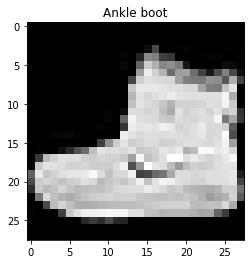

In [27]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

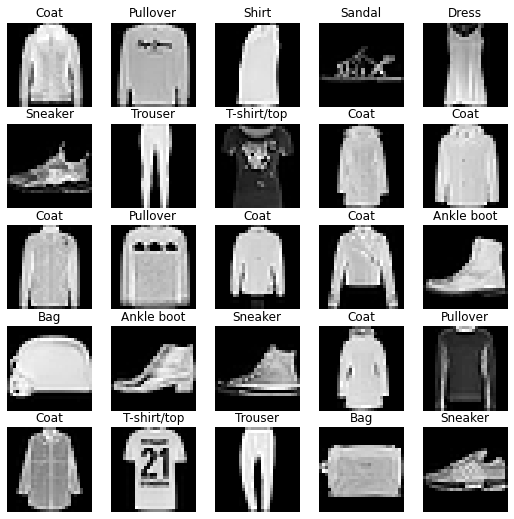

In [28]:
fig = plt.figure(figsize=(9,9))
rows, cols= 5, 5
for i in range(1, rows*cols+1):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [29]:
from  torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [30]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

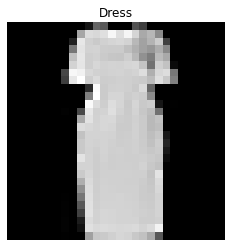

In [31]:
rand_idx = torch.randint(0, 32, size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [32]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [33]:
class ModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

model0 = ModelV0(784, 10, len(class_names)).to(device)
model0

ModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [34]:
def accuracy(y_true, y_pred):
    return ((torch.eq(y_true, y_pred).sum().item())/len(y_pred)) * 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model0.parameters(), lr=0.1)

In [35]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    t = end-start
    print(f"Train time on {device}: {t:.3f} seconds")

In [36]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    return train_loss

def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              acc_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss+=loss
            acc = acc_fn(y, y_pred.argmax(dim=1))
            test_acc+=acc
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

In [37]:
from tqdm.auto import tqdm

start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    train_loss = train_step(model0, train_dataloader, loss_fn, optimizer, device)
    
    test_loss, acc = test_step(model0, test_dataloader, loss_fn, accuracy, device)

    print(f"Train Loss: {train_loss:.5f} Test Loss: {test_loss:.5f} Acc: {acc:.5f}")        

end = timer()
print_train_time(start, end, device=str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.74793 Test Loss: 0.52224 Acc: 81.65935
Epoch: 1
Train Loss: 0.47518 Test Loss: 0.48328 Acc: 82.53794
Epoch: 2
Train Loss: 0.44364 Test Loss: 0.46443 Acc: 83.59625
Train time on cuda:0: 22.722 seconds


In [38]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model": model.__class__.__name__, "loss":loss.item(), "acc":acc}

model0_results = eval_model(model0, test_dataloader, loss_fn, accuracy)
model0_results

{'model': 'ModelV0', 'loss': 0.46443477272987366, 'acc': 83.59624600638978}